# **Predict Stroke**

- Import Library

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D


- Load Data

In [33]:
df = pd.read_csv('../dataset/stroke.csv')

In [40]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


## Data Preprocessing

- Handling Missing & Duplicated Values

In [36]:
df.duplicated().sum()

np.int64(0)

In [37]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Menggunakan drop nan dikarenakan untuk bmi ini jika di isi dengan mean atau median itu akan merusak data karena bmi sendiri itu termasuk yang mempengaruhi kemungkinan orang terkena stroke

In [38]:
df = df.dropna()

In [39]:
df = df[df['smoking_status'] != 'Unknown']
df = df[df['gender'] != 'Other']
df = df.drop(columns=['id'])

In [43]:
df.dtypes

gender                 int64
age                    int64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
dtype: object

In [41]:
df['age'] = df['age'].astype(int)

- Feature Engineering

In [49]:
label = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for i in label:
    df[i] = LabelEncoder().fit_transform(df[i])

X = df.drop('stroke', axis=1)
y = df['stroke']

scale = StandardScaler()
X_scale = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=42)


In [50]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67,0,1,1,2,1,228.69,36.6,0,1
2,1,80,0,1,1,2,0,105.92,32.5,1,1
3,0,49,0,0,1,2,1,171.23,34.4,2,1
4,0,79,1,0,1,3,0,174.12,24.0,1,1
5,1,81,0,0,1,2,1,186.21,29.0,0,1


## Modelling & Evaluation

In [51]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, verbose=1)

Epoch 1/10


d:\ML\ML-PredictNumerical\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8779 - loss: 0.4353 - val_accuracy: 0.9580 - val_loss: 0.1638
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9522 - loss: 0.1791 - val_accuracy: 0.9580 - val_loss: 0.1535
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9518 - loss: 0.1617 - val_accuracy: 0.9580 - val_loss: 0.1520
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9520 - loss: 0.1556 - val_accuracy: 0.9580 - val_loss: 0.1542
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9480 - loss: 0.1576 - val_accuracy: 0.9580 - val_loss: 0.1528
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9418 - loss: 0.1730 - val_accuracy: 0.9562 - val_loss: 0.1529
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9428 - loss: 0.1687 - val_accuracy: 0.9562 - val_loss: 0.1539
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9463 - loss: 0.1521 - val_accuracy: 0.9562 - val_loss: 0.1558
Epo

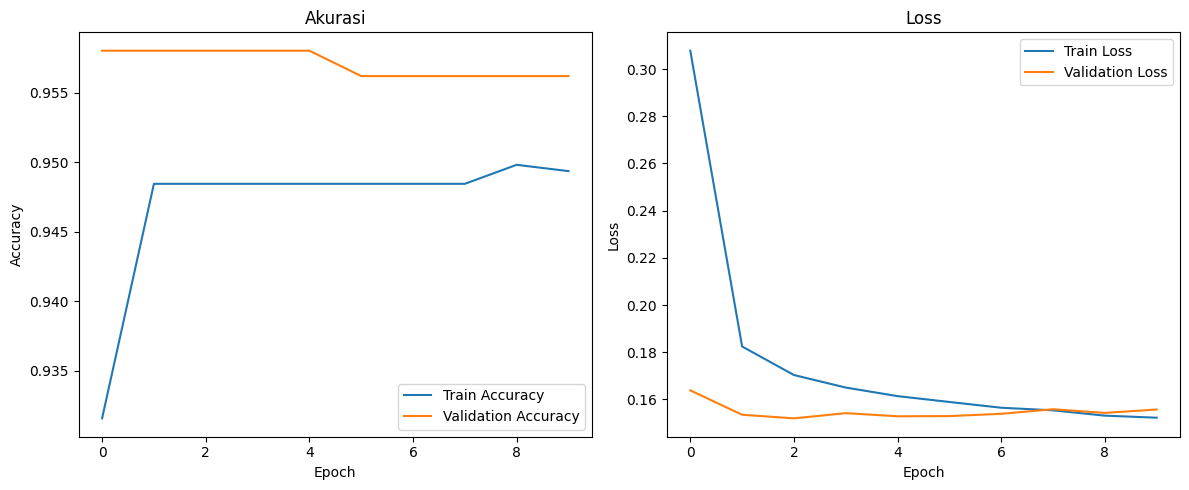

In [52]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_cnn, y_train, epochs=20, validation_split=0.2, verbose=1)

Epoch 1/20


d:\ML\ML-PredictNumerical\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9518 - loss: 0.4005 - val_accuracy: 0.9580 - val_loss: 0.1825
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9499 - loss: 0.2163 - val_accuracy: 0.9580 - val_loss: 0.1621
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9496 - loss: 0.1994 - val_accuracy: 0.9580 - val_loss: 0.1539
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9530 - loss: 0.1856 - val_accuracy: 0.9580 - val_loss: 0.1520
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9521 - loss: 0.1820 - val_accuracy: 0.9580 - val_loss: 0.1486
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9470 - loss: 0.1939 - val_accuracy: 0.9580 - val_loss: 0.1504
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9430 - loss: 0.2043 - val_accuracy: 0.9580 - val_loss: 0.1479
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9437 - loss: 0.2033 - val_accuracy: 0.9580 - val_loss: 0.1493
Epo

## Predict